# Cluster analysis and heatmaps

Author: Francesco Russo, frru@ssi.dk<br>
Last Update: August 25, 2022<br>

Notebook for the International Summer School on non-targeted metabolomics 2022.<br>

---

**Before starting to run this notebook with your own data, remember to save a copy of this notebook in your own Google Drive! Do so by clicking on File --> Save a copy in Drive. You can give whatever meaningful name to your notebook.** <br>
This file should be located in a new folder of your Google Drive named 'Colab Notebooks'. You can also download this notebook: File --> Download --> Download .ipynb. <br>

---

This notebook contains different cluster analyses to explore patterns in the data which help us to discover subgroups of samples or features that share a certain level of similarity. Clustering is an example of unsupervised learning where no labels are given to the learning algorithm which will try to find patterns/structures in the input data on its own. The goal of clustering is to find these hidden patterns.<br>

Some types of cluster analyses (e.g. hierarchical clustering) are often associated with heatmaps. Heatmaps are a visual representation of the data where columns are usually samples and rows are features (in our case, different metabolic features). The color scale of heatmaps indicates higher or lower intensity (for instance, blue is lower and red is higher intensity).<br>

There are a lot of good videos and resources out there explaining very well the principle behind clustering. Some good ones are the following:<br>
- Hierarchical clustering and heatmaps: https://www.youtube.com/watch?v=7xHsRkOdVwo<br>
- K-means clustering: https://www.youtube.com/watch?v=4b5d3muPQmA
- ComplexHeatmap R package: https://jokergoo.github.io/ComplexHeatmap-reference/book/ 

**Data**

The files used in this tutorial are part of an interlab comparison study, where different laboratories around the world analysed same environmental samples on their respective LC-MS/MS equipments. To simulate algal bloom, standardized algae extracts (A) in marine dissolved organic matter (M) at different concentrations were prepared (450 (A45M), 150 (A15M), and 50 (A5M) ppm A). Samples were then shipped to different laboratories for untargeted LC-MS/MS metabolomics analysis. In this tutorial we are working with one of the datasets, which was acquired on a UHPLC system coupled to a Thermo Scientific Q Exactive HF Orbitrap LC-MS/MS mass spectrometer. MS/MS data were acquired in data-dependent acquisition (DDA) with fragmentation of the five most abundant ions in the spectrum per precursor scan. Data files were subsequently preprocessed using MZmine3 and the feature-based molecular networking workflow in GNPS.<br>

**Questions**

- Can we monitor algal bloom by looking at metabolomic profiles of marine dissolved organic matter?
- Are we able to group/cluster together samples derived from different concentrations of algae extracts using metabolic profiles? <br>
- Which samples are the most similar? <br>
- Are there any patterns defining the groups/clusters? That is, which features cluster together? 

In [1]:
# Last update
Sys.time()

[1] "2022-08-25 11:06:05 UTC"

**Install packages**

In [2]:
# It might take some time in Google Colab
install.packages("BiocManager")
BiocManager::install("ComplexHeatmap")
install.packages(c("dplyr","dendextend","NbClust","factoextra"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.1 (2022-06-23)

Installing package(s) 'BiocVersion', 'ComplexHeatmap'

also installing the dependencies ‘shape’, ‘rjson’, ‘BiocGenerics’, ‘S4Vectors’, ‘iterators’, ‘circlize’, ‘GetoptLong’, ‘clue’, ‘GlobalOptions’, ‘png’, ‘IRanges’, ‘matrixStats’, ‘foreach’, ‘doParallel’


Old packages: 'callr', 'devtools', 'dtplyr', 'forcats', 'gert',
  'googlesheets4', 'haven', 'hms', 'httr', 'knitr', 'modelr', 'pillar',
  'readxl', 'reprex', 'rmarkdown', 'roxygen2', 'rstudioapi', 'rvest', 'scales',
  'stringr', 'tibble', 'tidyverse', 'tinytex', 'viridisLite', 'cluster'

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM

**Load libraries**

In [3]:
library("dplyr")
library("ComplexHeatmap")
library("dendextend")
library("NbClust")
library("factoextra")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.12.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



---------------------
Welcome to dendextend version 1.16.0
Type cita

**Importing feature table and metadata**<br>
In the following, we import the cleaned and imputed feature table (performed by Abzer, GitHub: @abzer005) for the example dataset (**Lab15**). Copy and paste the path of your files into the **ft_url** and **md_url**.


In [54]:
# We import the cleaned and imputed feature table after we have uploaded the files in Google Colab
ft_url <- '/content/Imputed_QuantTable_filled_with_1267_CutOff_Used_0.3.csv'
# metadata
md_url <- '/content/metadata_dom_interlab_lab15.txt'

In [53]:
# To import the files located in GitHub:
# ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/processed/Imputed_QuantTable_filled_with_1267_CutOff_Used_0.3.csv'
# md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/metadata_lab15.txt'

In [55]:
# read data
ft <- read.csv(ft_url, header = T, check.names = F, row.names = 1)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t', row.names = 1)

In [56]:
# dimension of the data
dim(ft)
dim(md)

[1] 2395   12

[1] 13  3

In [57]:
head(ft)

,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3488_151.112_9.684,92659.64,107936.65,90535.35,84885.34,95607.41,92654.02,88818.610,91449.840,72474.910,72892.23,86713.87,123999.58
3026_153.091_8.525,226318.05,234986.17,238839.39,139233.22,145115.98,171750.98,194286.900,189326.750,215591.770,201655.44,221566.31,235400.44
685_153.139_5.391,22815.65,47993.26,40643.11,134512.40,135856.67,135126.06,8692.169,8439.676,9102.462,1267.00,1267.00,1267.00
3819_157.101_10.487,79142.02,73783.61,68608.62,99552.16,105480.26,104682.83,61277.125,64415.734,58878.953,58953.49,72545.66,59660.09
445_158.097_4.702,179699.17,189614.48,189814.78,113440.05,130959.01,192133.47,158486.980,63555.760,152527.080,185849.10,167359.47,135441.61
3501_158.154_9.708,167225.03,165643.97,179723.14,37863.93,29725.38,36029.86,130394.164,130174.766,139707.340,112410.28,128730.17,125169.77


In [58]:
head(md)

,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
,<chr>,<chr>,<int>
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,A5M,Sample,5
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,A5M,Sample,5
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,A5M,Sample,5
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,A15M,Sample,15


In [59]:
# show the type and number of samples we have
table(md$ATTRIBUTE_Sample)


A15M A45M  A5M    M  PPL 
   3    3    3    3    1 

**Bring feature table and metadata in the correct format**

In [60]:
# how many files in the metadata are also present in the feature table
table(rownames(md) %in% colnames(ft))


FALSE  TRUE 
    1    12 

In [61]:
# which file names in the metadata are not in the feature table?
setdiff(rownames(md),colnames(ft))

[1] "DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML"

The blank sample 'DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML' is not in the feature table, we thus remove it also from the metadata (it was used in the data clean up step).

In [62]:
md <- md[rownames(md) %in% colnames(ft),]

In [63]:
dim(md)

[1] 12  3

In [64]:
# transpose ft
ft <- t(ft)

In [65]:
head(ft)

,3488_151.112_9.684,3026_153.091_8.525,685_153.139_5.391,3819_157.101_10.487,445_158.097_4.702,3501_158.154_9.708,4044_159.117_10.771,950_160.076_5.809,275_160.076_1.42,6487_161.082_14.715,⋯,6601_881.502_15.873,1548_891.382_6.437,6521_908.63_15.046,6543_934.645_15.302,6544_936.66_15.304,4973_1130.617_12.106,4989_1135.573_12.104,6520_1380.023_15.045,6522_1402.005_15.04,6270_1436.084_13.449
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,92659.64,226318.0,22815.65,79142.02,179699.2,167225.03,87909.88,173039.22,43021.49,26619.26,⋯,1267,15763.91,17379.76,98856.890,167678.7,109611.17,182962.88,85050.39,28233.84,37029.5
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,107936.65,234986.2,47993.26,73783.61,189614.5,165643.97,104461.99,174041.17,39680.26,274401.88,⋯,1267,17169.22,1267.00,1267.000,1267.0,120312.62,184130.48,93540.20,39000.38,1267.0
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,90535.35,238839.4,40643.11,68608.62,189814.8,179723.14,112714.16,168169.86,37331.12,535480.80,⋯,1267,20009.32,1267.00,1267.000,1267.0,110909.55,197381.10,90643.89,34778.47,1267.0
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,84885.34,139233.2,134512.40,99552.16,113440.1,37863.93,103441.48,69424.34,38532.68,163050.66,⋯,1267,76855.44,1267.00,2394.057,1267.0,14802.72,94343.87,183492.10,58418.86,1267.0
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,95607.41,145116.0,135856.67,105480.26,130959.0,29725.38,149735.70,99507.48,40953.70,54522.12,⋯,1267,72523.40,1267.00,1267.000,156763.4,31035.53,88939.61,193421.60,48551.90,1267.0
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,92654.02,171751.0,135126.06,104682.83,192133.5,36029.86,106454.25,71854.24,35524.65,60506.51,⋯,1267,79819.65,1267.00,1267.000,1267.0,69041.09,115808.11,176675.10,42665.52,18745.9


In [66]:
dim(ft)

[1]   12 2395

**Clustering analysis and heatmaps**

In the following code, we will perform a clustering analysis and visualize a heatmap. We will 'decorate' our heatmap with some annotations derived from the metadata to show 'ATTRIBUTE_Sample' and 'ATTRIBUTE_Time-Point'. We will use the R package ComplexHeatmap (https://jokergoo.github.io/ComplexHeatmap-reference/book/introduction.html) which is a very flexible package for visualizing heatmaps (not just one! It is also possible to combine several heatmaps! It means you can plot for example one heatmap for the showing untargeted metabolomics, one with gene expression data, one for genetics etc etc).

In [67]:
identical(rownames(ft),rownames(md))
# put the rows in the feature table and metadata in the same order
ft <- ft[match(rownames(md),rownames(ft)),]
identical(rownames(ft),rownames(md))

[1] FALSE

[1] TRUE

It is important that you scale your feature values in order to obtain a meaningful clustering. Each samples' feature values are represented as coordinates in n-dimensional space (n is the number of features) and then the distances between these coordinates are calculated. If these coordinates are not normalized you can get misleading/false results.<br>

The following scale() function will ensure your distribution of feature values has mean 0 and a standard deviation of 1.

In [68]:
# center and scale data
fts <- scale(ft, center = T, scale = T)

In [69]:
head(fts)

,3488_151.112_9.684,3026_153.091_8.525,685_153.139_5.391,3819_157.101_10.487,445_158.097_4.702,3501_158.154_9.708,4044_159.117_10.771,950_160.076_5.809,275_160.076_1.42,6487_161.082_14.715,⋯,6601_881.502_15.873,1548_891.382_6.437,6521_908.63_15.046,6543_934.645_15.302,6544_936.66_15.304,4973_1130.617_12.106,4989_1135.573_12.104,6520_1380.023_15.045,6522_1402.005_15.04,6270_1436.084_13.449
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,-0.20850908,-0.2001257,-0.65787361,-0.7988105,0.09224146,0.2887988,-0.96101640,-0.11385005,-1.3017316,-0.5336943,⋯,-0.2886751,-0.5692503,-0.3531971,-0.4220698,-0.5524475,-0.7556835,-0.8736557,-0.6781482,-0.5811113,-0.6190971
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,-0.01934697,-0.3442869,-0.66237645,-0.6235413,-2.35357512,0.2846195,-0.05228363,0.09267484,1.0182057,-0.3923485,⋯,-0.2886751,-0.4673384,-0.3531971,-0.4220698,1.6259794,-0.7556835,-0.8736557,-0.6469316,-0.5539240,-0.1338940
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,-1.38347621,0.4190766,-0.65055663,-0.9327315,-0.06130995,0.4662033,0.31024363,0.62077611,1.0584983,-0.5248627,⋯,-0.2886751,-0.5817466,-0.3531971,-0.4220698,-0.5524475,-0.7556835,-0.8736557,-0.6381397,-0.4394481,0.2769632
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,0.06762692,0.7308239,-0.40600212,0.1988181,0.63875425,0.9903816,-0.44118719,1.29157878,1.6403060,-0.5428433,⋯,-0.2886751,-0.3956903,0.4402577,1.6343274,1.7484851,1.4368258,1.3517599,0.1260390,0.1673888,0.2402756
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,1.16590850,0.9827531,0.04300358,-0.1004114,0.89421320,0.9602644,0.32594015,1.31970705,0.4361277,1.0701164,⋯,-0.2886751,-0.3486645,-0.3531971,-0.4220698,-0.5524475,1.6533861,1.3660607,0.2410766,0.7114103,-0.6190971
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,-0.08509069,1.0947427,-0.08807563,-0.3893979,0.89937374,1.2284553,0.70839673,1.15487866,-0.4105017,2.7696293,⋯,-0.2886751,-0.2536269,-0.3531971,-0.4220698,-0.5524475,1.4631006,1.5283546,0.2018313,0.4980819,-0.6190971


**Hierarchical Clustering Algorithm**

We are now ready to perform a cluter analysis. The concept behind hierarchical clustering is to repeatedly combine the two nearest clusters into a larger cluster. <br>

1. The first step consists of calculating the distance between every pair of observation points and stores it in a matrix;<br>
2. It puts every point in its own cluster;<br>
3. It merges the closest pairs of points according to their distances;<br>
4. It recomputes the distance between the new cluster and the old ones and stores them in a new distance matrix;<br>
5. It repeats steps 2 and 3 until all the clusters are merged into one single cluster.<br>

In the following step we calculate the distance between data points based on Euclidean distance. You can choose another proper distance for continuous values here https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/dist. For example: 'manhattan', 'canberra', 'minkowski'.

In [70]:
# compute distance
distm <- dist(fts, method = "euclidean")

Next, we perform the hierarchical clustering. As you can see in the following code we need to specify the 'method' argument. This argument tells the algorithm how to measure the distance between clusters and it's usually referred as 'Linkage Method'. There are several and you can explore different options here https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/hclust. Usually, you will try different ones and plot the result.<br>

Here, we use the default 'complete' (i.e. complete-linkage), which calculates the maximum distance between clusters before merging.

In [71]:
# we set a seed to get always the same result
set.seed(1234)
hclust_res <- hclust(distm, method = 'complete')

Then, we plot the result. In hierarchical clustering, we visualize the cluster relationships in a tree-like diagram called dendrogram. The distance of split or merge is called height.

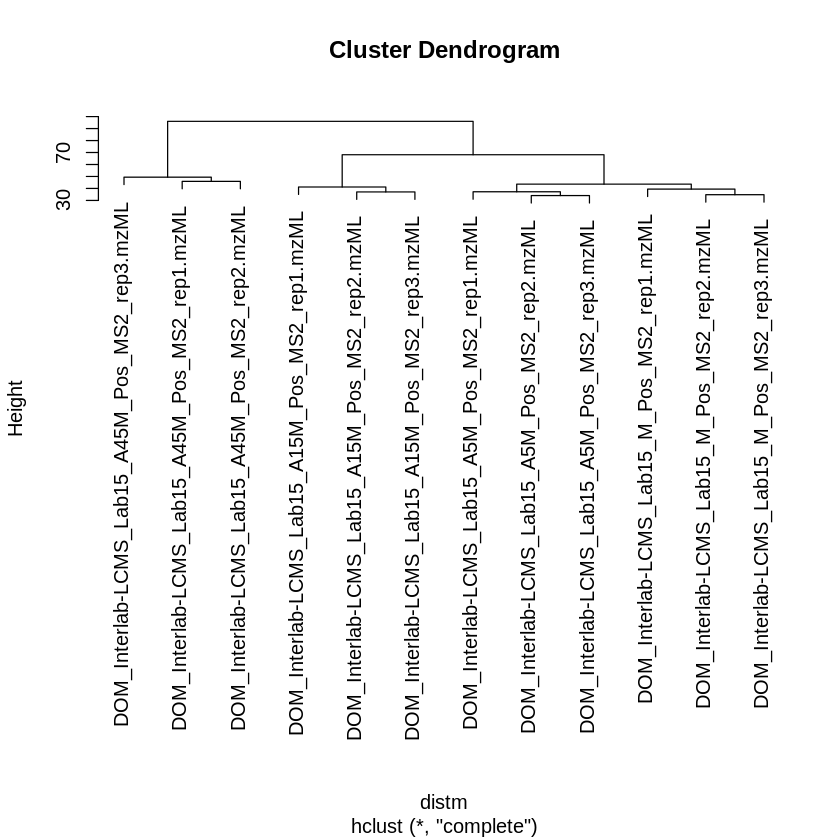

In [72]:
plot(hclust_res)

Next, you can cut the dendrogram to create the desired number of clusters. In this case it seems we have 2 main 'splits', further divided into a total of 3 clusters. We are going to use the cutree() function for this https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/cutree. 

In [73]:
cut_res <- cutree(hclust_res, k = 3) # where k indicates the number of clusters we want

In [74]:
# the cluster assignment
data.frame(cut_res)

,cut_res
,<int>
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,1
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,1
DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,1
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,2
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,2
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,2
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,3
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,3
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,3


In [75]:
# you can also count how many samples are in each cluster
table(data.frame(cut_res))

cut_res
1 2 3 
6 3 3 

We can highlight the clusters in the dendrogram as well.



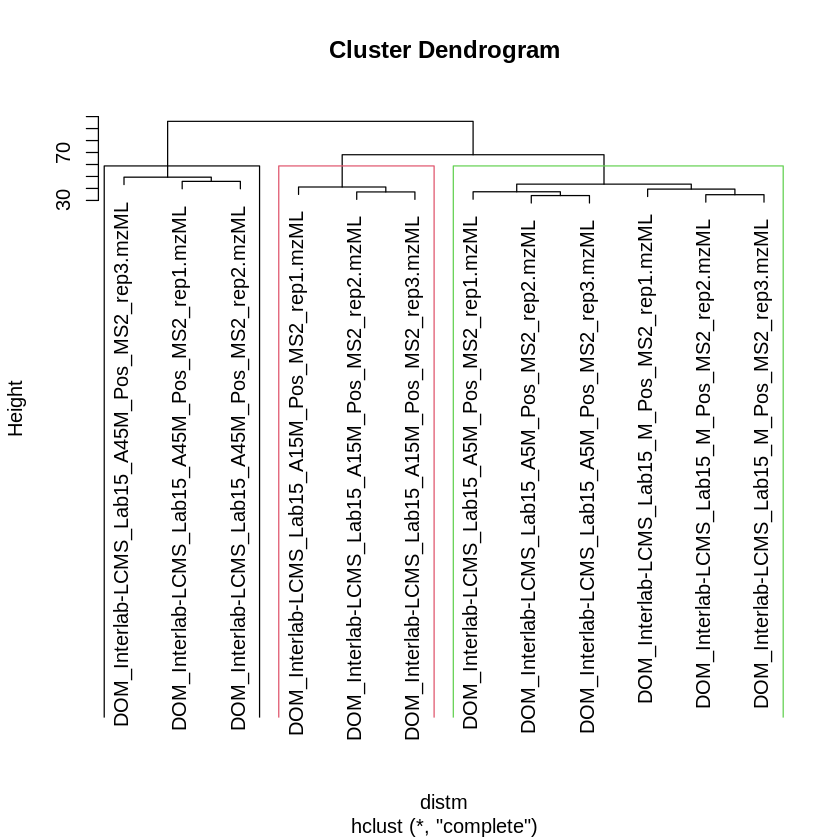

In [76]:
plot(hclust_res)
rect.hclust(hclust_res, k = 3, border = 1:3)

We can color the samples by cluster assignment using the dendextend package.

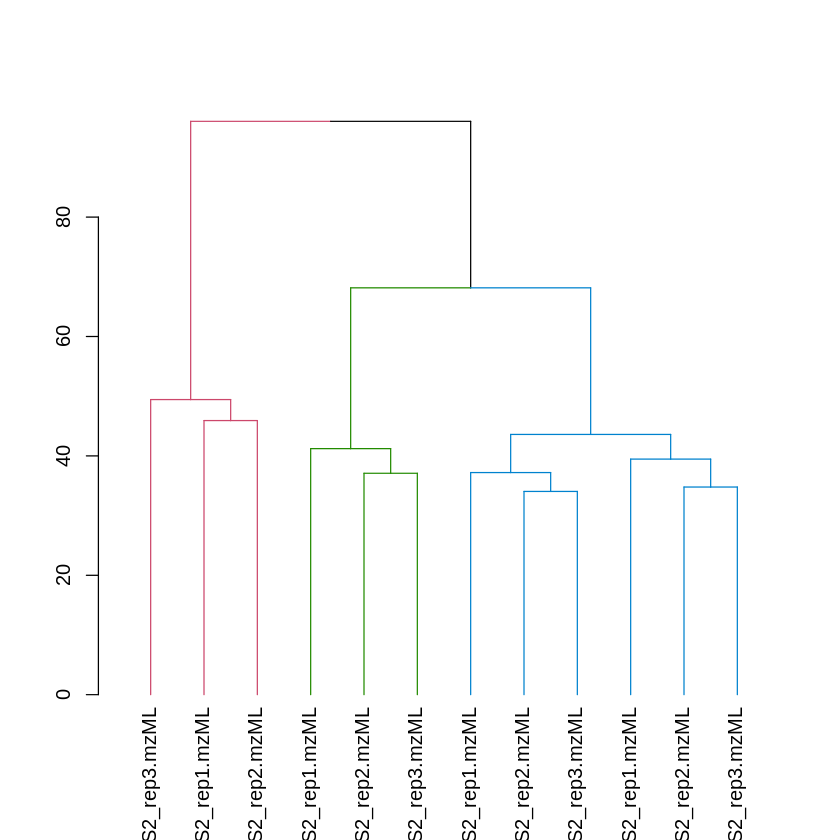

In [77]:
dend_obj <- as.dendrogram(hclust_res)
col_dend <- color_branches(dend_obj, k = 3)
plot(col_dend)

**Can we define the number of clusters using a simple approach? We are going to use the NbClust and factoextra packages for this purpose.**<br>

We start with the Elbow approach. The Elbow method looks at the total within-cluster sum of square (WSS) as a function of the number of clusters.
WSS: sum of distances between the points and the corresponding centroids for each cluster. 

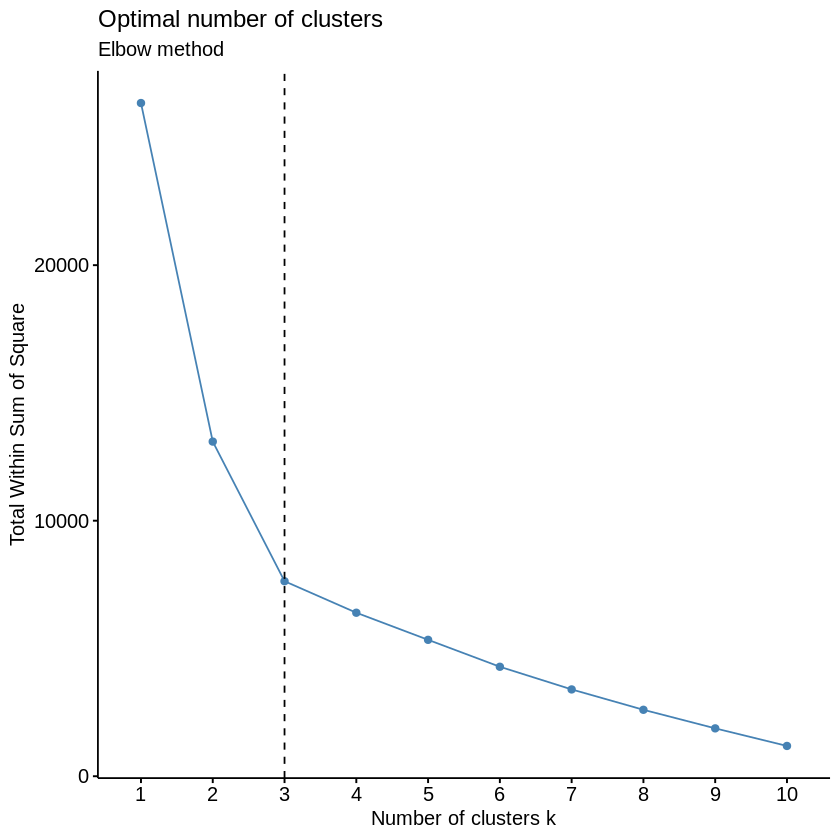

In [78]:
# Elbow method. Here we use 'hcut' which computes the hierarchical clustering and cut the tree. Other methods are available (https://www.rdocumentation.org/packages/factoextra/versions/1.0.7/topics/fviz_nbclust)
fviz_nbclust(fts, hcut, method = "wss") +
  geom_vline(xintercept = 3, linetype = 2) + # add line indicating what you think is the optimal number of clusters
  labs(subtitle = "Elbow method") # add subtitle

The location of a 'elbow' in the plot is usually considered as an indicator of the appropriate number of clusters because it means that adding another cluster does not improve the grouping. This method seems to suggest 3 clusters. However, the Elbow method is sometimes ambiguous. As we can see from the plot above, the 'elbow' could be located at 2 or 3 clusters. <br>
An alternative is the average silhouette method. The Silhouette method measures the quality of a clustering and determines how well each point lies within its cluster.

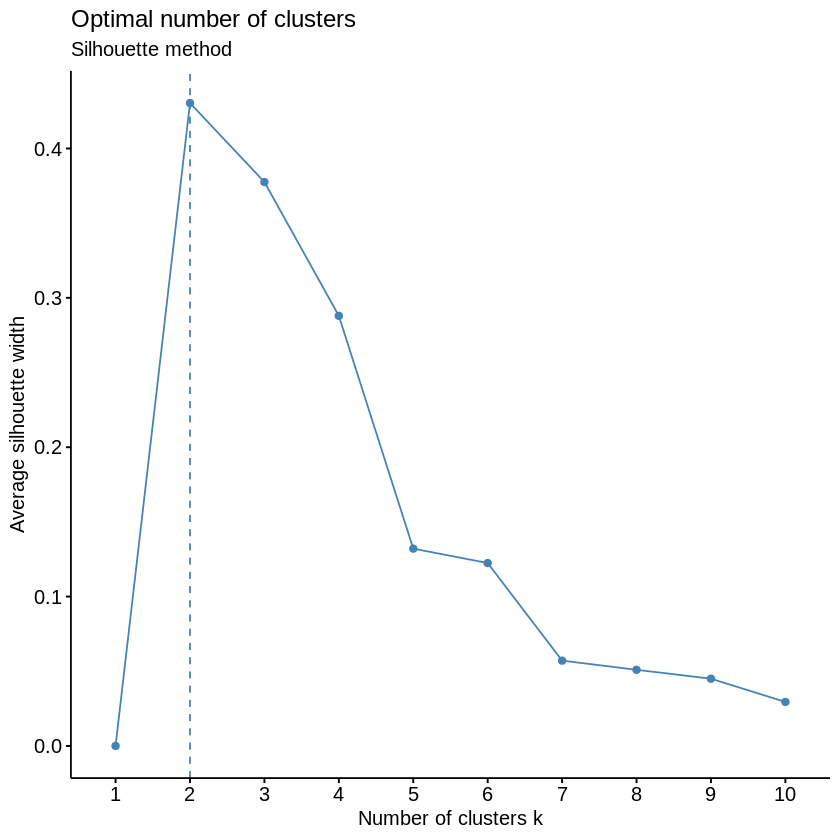

In [79]:
# Silhouette method
fviz_nbclust(fts, hcut, method = "silhouette") +
  labs(subtitle = "Silhouette method")

In this case, the silouette method seems to find 2 main clusters. There are several other methods to discover the optimal number of clusters and sometimes they do not fully agree. Often, you will need to bring your own knowledge about the specific field to decide whether the number of clusters makes sense.

As you can see, no matter which approach we use for finding the optimal number of clusters, the hierarchical clustering was able to identify meaningful clusters. However, based on the parameters that we have selected it seems that sample types 'M' and 'A5M' cluster together. Is this meaningful?<br>

Sometimes, you may get unexpected results that are not only related to the selection of parameters but also to the input data. For instance, noisy data will lead to different clusters and interpretation of the results. For example, you could consider to remove features having zero-variance or zero Median Absolute Deviation prior to perform any further downstream analysis (remember that we usually impute quite a lot of data in metabolomics and this could create this zero-variance issue).


In [80]:
# If you want to remove features having zero Median Absolute Deviation, you can use the following function (just replace 'mad' with 'var' for the variance).
removeZeroMad <- function(df){
  df[, sapply(df, mad) != 0]
}

In [81]:
# we apply the function to the input data before scaling
ft_noZeroMad <- removeZeroMad(as.data.frame(ft))

As you can see, some features were removed after this filtering step.

In [82]:
dim(ft_noZeroMad)

[1]   12 2333

What happens if we perform clustering again?

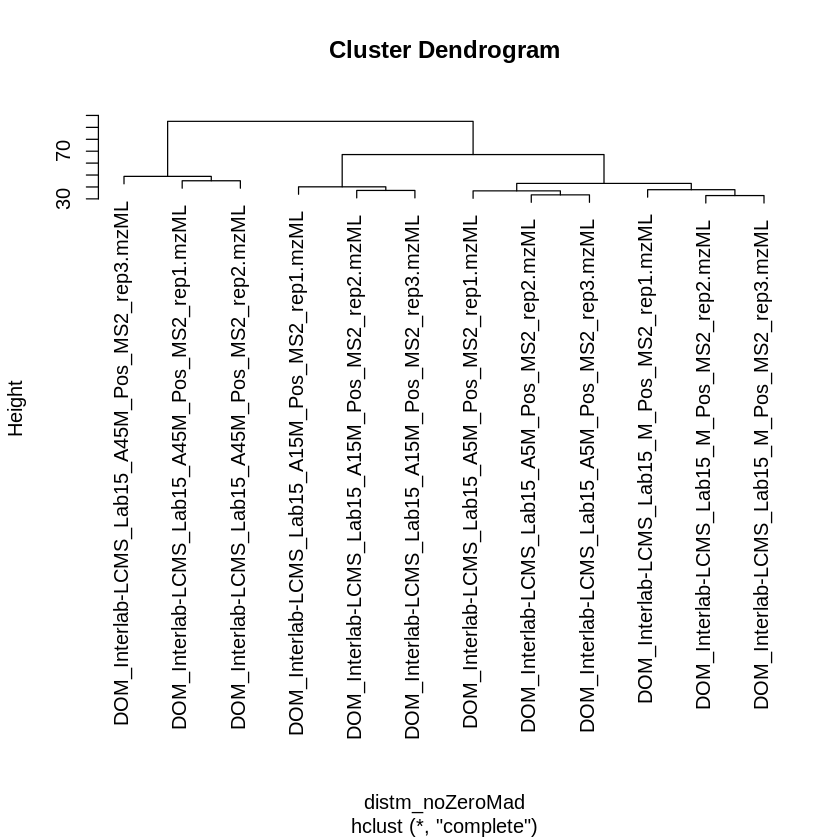

In [83]:
# first, we scale the matrix
ft_noZeroMad_s <- scale(ft_noZeroMad, scale = T, center = T)
# then we calculate the distance matrix
distm_noZeroMad <- dist(ft_noZeroMad_s, method = "euclidean")
# then we perform clustering
set.seed(1234)
hclust_noZeroMad <- hclust(distm_noZeroMad, method = 'complete')
# finally, we plot the result
plot(hclust_noZeroMad)

In this case, the result is not affected and 'M' and 'A5M' samples still cluster together. This is also a nice proof that the noisy features that we have removed might not contribute much to the clustering and the interpretation of the result is still the same. Therefore, 'M' and 'A5M' samples share clear metabolic similarities.

**Heatmaps**

In the next section we will add an additional layer in our visualization by plotting a heatmap together with the hierarchical clustering.<br>

First, we prepare the 'decoration' for our heatmap. We want to show the 'ATTRIBUTE_Sample' and 'ATTRIBUTE_Time-Point' colored in a distinctive way. It is much easier to read the heatmap in this way.<br>

We are going to use the ComplexHeatmap package https://jokergoo.github.io/ComplexHeatmap/reference/Heatmap.html 

In [84]:
# metadata of interest
table(md$`ATTRIBUTE_Time-Point`)
table(md$ATTRIBUTE_Sample)


 0  5 15 45 
 3  3  3  3 


A15M A45M  A5M    M 
   3    3    3    3 

In [85]:
# prepare a dataframe with just the metadata of interest
ann <- data.frame(md$ATTRIBUTE_Sample, md$`ATTRIBUTE_Time-Point`)
# assign better column names to the dataframe
colnames(ann) <- c('Sample', 'Time_point')
# select some colors of your choice. You can explore more colors by using the RColorBrewer package or by simply check for the hex code https://www.color-hex.com/
colours <- list('Sample' = c('M' = 'grey', 'A5M' = 'darkorange', 'A15M' = 'darkred', 'A45M' = 'darkgreen'),
  'Time_point' = c('0' = 'grey', '5' = 'darkorange', '15' = 'darkred', '45' = 'darkgreen'))
# the function in ComplexHeatmap for preparing the annotation object 
colAnn <- HeatmapAnnotation(df = ann,
  col = colours,
  annotation_width = unit(c(1, 4), 'cm'),
  gap = unit(1, 'mm'))

ComplexHeatmap gives you a flexible function and it is easy to change parameters. You can take a look at the options here https://jokergoo.github.io/ComplexHeatmap/reference/Heatmap.html <br>

In the following, we will perform hierarchical clustering based on Euclidean distance. ComplexHeatmap uses the R package hclust for this purpose, that we already saw in the previous section. As we said, Euclidean distance is just an example that fits well continuous numerical values in your dataset but there are several distance measures such as Manhattan, Minkowski, Canberra etc.<br>
If you have binary data, you may consider to use Jaccard distance.

In [86]:
# set the parameters for the type of clustering to perform. You can play with different options
set.seed(1234)
hmap <- Heatmap(
  t(fts),
  heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
  col = c("blue","white","darkred"),
  show_row_names = FALSE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  show_column_dend = TRUE,
  show_row_dend = TRUE,
  row_dend_reorder = TRUE,
  column_dend_reorder = TRUE,
  clustering_distance_rows = "euclidean",
  clustering_distance_columns = "euclidean",
  clustering_method_rows = "complete",
  clustering_method_columns = "complete",
  width = unit(100, "mm"),
  top_annotation = colAnn)


`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



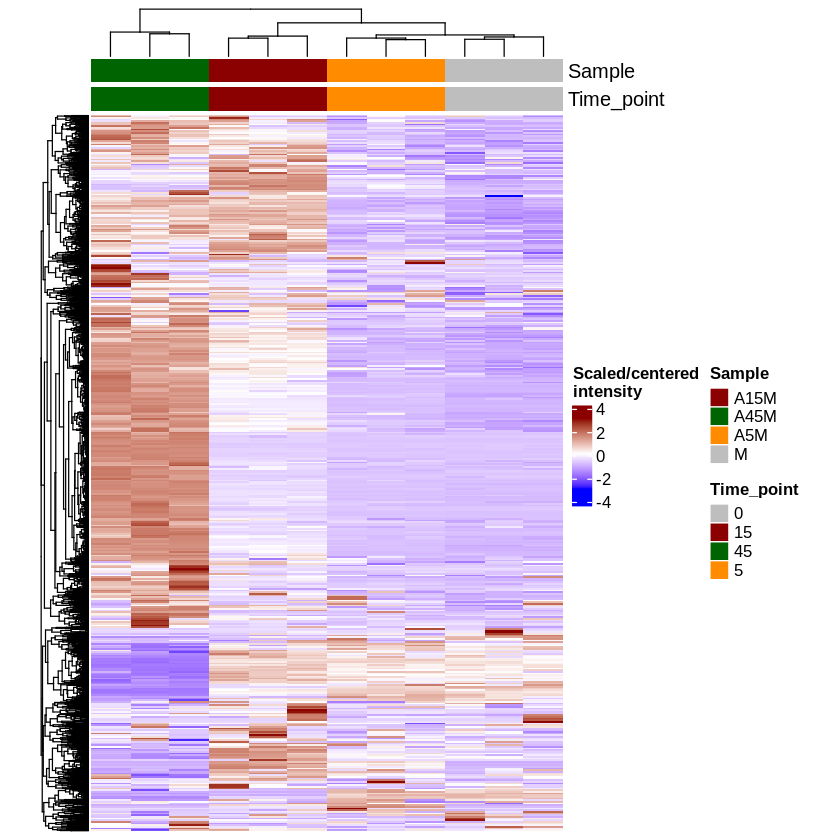

In [87]:
# draw heatmap. It can take some time if your input data is quite large
draw(hmap, heatmap_legend_side="right", annotation_legend_side="right")

As we can see, by using this type of visualization we can clearly observe the similarities between samples and features, in particular we can see again that sample types 'M' and 'A5M' are quite similar. We can also apply a method for dividing the heatmap according to a cluster assignment, similarly to the cutree() step, for generating better visualizations that can help the interpretation of the results.<br>

ComplexHeatmap contains a function to find clusters by using another clustering algorithm called **k-means**.

In [88]:
# set the parameters for the type of clustering to perform. You can play with different options
set.seed(1234)
hmap_km <- Heatmap(
  t(fts),
  heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
  col = c("blue","white","darkred"),
  show_row_names = FALSE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  show_column_dend = TRUE,
  show_row_dend = TRUE,
  row_dend_reorder = TRUE,
  column_dend_reorder = TRUE,
  clustering_distance_rows = "euclidean",
  clustering_distance_columns = "euclidean",
  clustering_method_rows = "complete",
  clustering_method_columns = "complete",
  width = unit(100, "mm"),
  top_annotation = colAnn,
  # parameters to perform k-means clustering. row_km indicates the number of clusters you want in the rows; column_km is referred to the number of clusters you want in the columns
  row_km = 3, row_km_repeats = 100,
  column_km = 3, column_km_repeats = 100)


`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



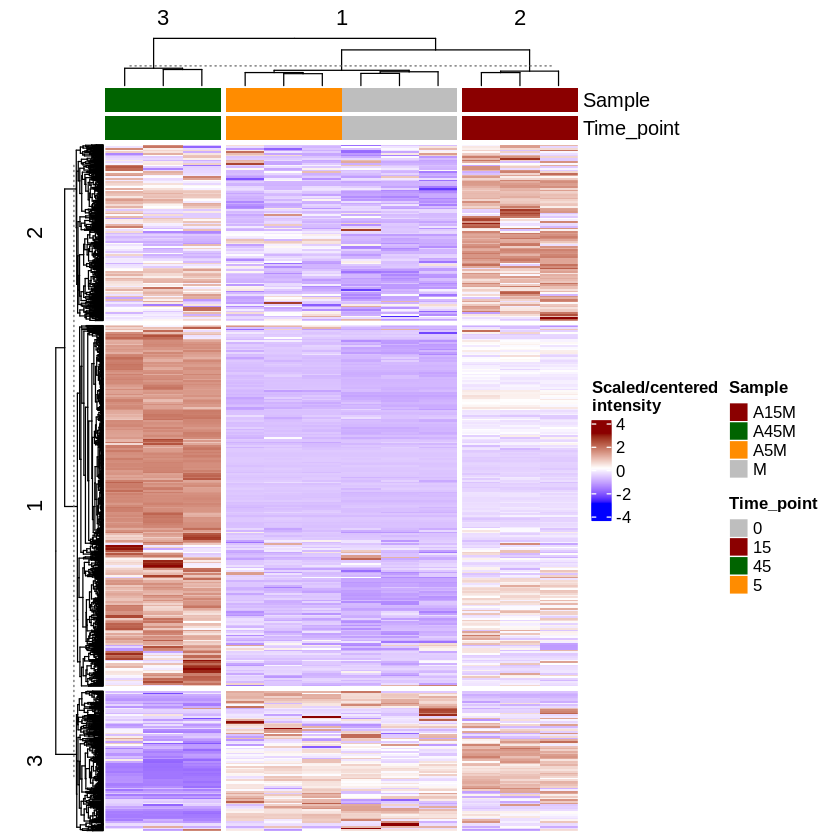

In [89]:
# draw heatmap. It can take some time if your input data is quite large
draw(hmap_km, heatmap_legend_side="right", annotation_legend_side="right")

In the next step, we extract the features belonging to the clusters for future use.

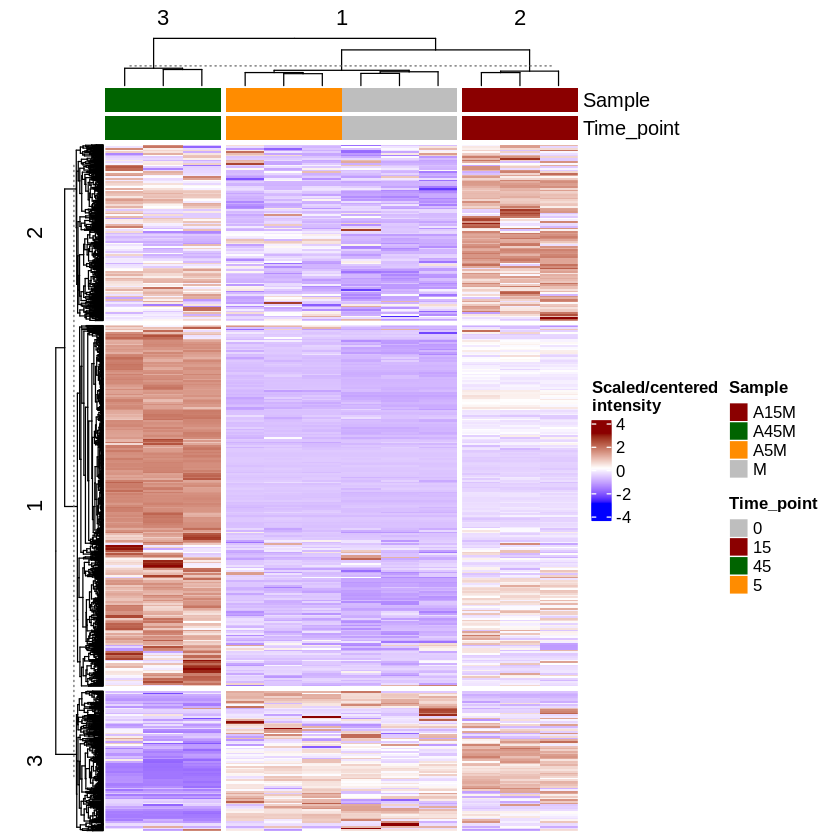

In [90]:
row_order_res <- row_order(draw(hmap_km, heatmap_legend_side="right", annotation_legend_side="right"))  

In [91]:
# check/confirm size of clusters
lapply(row_order_res, function(x) length(x))  

$`2`
[1] 623

$`1`
[1] 1277

$`3`
[1] 495

In [92]:
# loop to extract features for each cluster
out_res <- NULL
for (i in seq_along(row_order_res)){
out_res[[i]] <- cbind(colnames(fts[,row_order_res[[i]]]), paste("cluster", i, sep=""))  
}

In [93]:
out_res <- as.data.frame(do.call(rbind, out_res))

In [94]:
colnames(out_res) <- c('feature','cluster')

In [95]:
# dimension of the object
dim(out_res)
# number of features in each cluster
table(out_res$cluster)
head(out_res)

[1] 2395    2


cluster1 cluster2 cluster3 
     623     1277      495 

,feature,cluster
,<chr>,<chr>
1,4851_219.174_11.931,cluster1
2,5007_346.259_12.115,cluster1
3,6325_416.337_13.538,cluster1
4,3978_279.158_10.695,cluster1
5,1289_277.155_6.177,cluster1
6,964_334.201_5.823,cluster1


You can export the data frame and plots for future use by saving it in Google Colab. It will be saved in the **content** folder and then you can download it in your computer.


In [96]:
# save the data frame with cluster information
write.table(out_res, file = "/content/feature_clusters.txt", sep="\t", quote = F, row.names = FALSE)

In [97]:
# save the heatmap in pdf format. You can import this plot in Illustrator or similar program to modify the vector image
pdf(file = '/content/heatmap.pdf')
draw(hmap_km, heatmap_legend_side="right", annotation_legend_side="right")
dev.off()

png 
  2

**Summary**

In this notebook you have performed hierarchical clustering, found optimal number of clusters, plotted heatmaps and performed K-means clustering to obtain well defined clusters. In the last step, we have extracted a data frame with feature id and cluster assignment. You can use this output for further analyses. For example, you could add the annotation of the features obtained elsewhere using GNPS or Sirius and check if the clustering makes sense at a class level. You might want to play with different settings by changing the parameters for the clustering.<br>

**Notes**: usually, finding the correct number of clusters is not a trivial task and it is also an open scientific question. However, several methods are available to help us in the decision. There are several R packages to help us in this task:<br>
https://cran.r-project.org/web/packages/NbClust/index.html <br>
https://cran.r-project.org/web/packages/fpc/index.html <br>

These packages can also be used for determining the stability of the clusters (that is, are the clusters assigned by random chance?). <br>

Remember that no matter what, you will also obtain some clusters. It's important to be careful with interpretations. There are more advanced and complex methods for finding clusters. A very good one is WGCNA (https://cran.r-project.org/web/packages/WGCNA/index.html), initially developed for microarray/RNA-seq data, it can be used to cluster metabolic features as well. 

In [98]:
# for reproducibility
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] factoextra_1.0.7      ggplot2_3.3.6         NbClust_3.0.1        
[4] dendextend_1.16.0     ComplexHeatmap_2.12.1 dplyr_1.0.9          

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.9          ggrepel_0.9.1       circlize_0.4.15    
 [4] ti